In [2]:
%pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 1.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.4 MB 1.3 MB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.4 MB 1.5 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.4 MB 1.4 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.4 MB 1.7 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.4 MB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.4 MB 2.3 MB/s eta 0:00:01
   ----------------------- ---------------- 0.8/1.4 MB 2.3 MB/s eta 0:00:01
   -------------------------- ------------- 1.0/1.4 MB 2.3 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.4 MB 2.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 2.4 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.4 MB 2.3 MB/s eta 0:00:01
   ----------------

In [3]:
%pip install shap

   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/456.2 kB 1.7 MB/s eta 0:00:01
   ------------ --------------------------- 143.4/456.2 kB 1.4 MB/s eta 0:00:01
   ------------------- -------------------- 225.3/456.2 kB 1.7 MB/s eta 0:00:01
   ------------------------- -------------- 286.7/456.2 kB 1.6 MB/s eta 0:00:01
   --------------------------------- ------ 378.9/456.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
import numpy as np

# Load the dataset
try:
    df = pd.read_csv(r"customer_booking.csv", encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(r"customer_booking.csv", encoding='latin-1')
    except UnicodeDecodeError:
        df = pd.read_csv(r"customer_booking.csv", encoding='utf-16')

# Handle missing values for numeric columns with median
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle missing values for categorical columns (if any)
categorical_cols = df.select_dtypes(exclude='number').columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with mode

# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Define target and features
target = 'booking_complete'
features = df.columns.drop(target)

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Example feature engineering
df['passenger_stay_interaction'] = df['num_passengers'] * df['length_of_stay']
df['booking_to_flight_time'] = df['purchase_lead'] / df['flight_hour']


In [ ]:
# Define the parameter grid to search over
param_grid = {
    'num_leaves': [15, 31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [-1, 5, 10, 20],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Initialize LightGBM classifier
lgb_classifier = lgb.LGBMClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
best_lgb = grid_search.best_estimator_
y_pred = best_lgb.predict(X_test)

Accuracy: 0.8533
Precision: 0.5844
Recall: 0.0304
F1-score: 0.0578
AUC: 0.5133


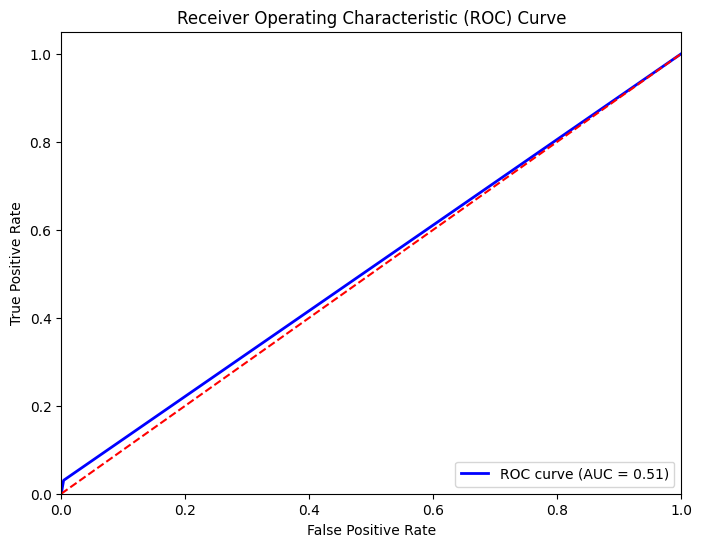

Confusion Matrix:
[[8488   32]
 [1435   45]]


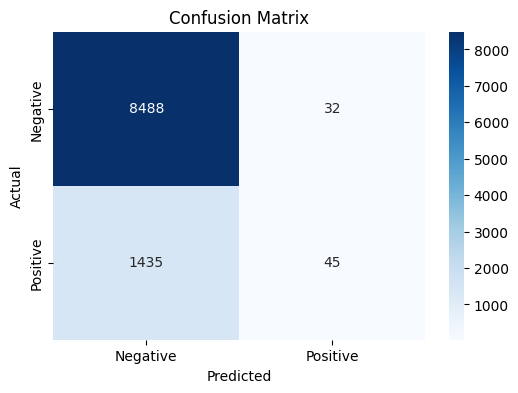

Accuracy: 0.8533
F1-Score: 0.0578
AUC Score: 0.5133
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      8520
           1       0.58      0.03      0.06      1480

    accuracy                           0.85     10000
   macro avg       0.72      0.51      0.49     10000
weighted avg       0.82      0.85      0.79     10000



In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, classification_report, roc_auc_score

y_pred_class = np.round(y_pred)

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))


c:\Users\JAYESH AHIRE\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


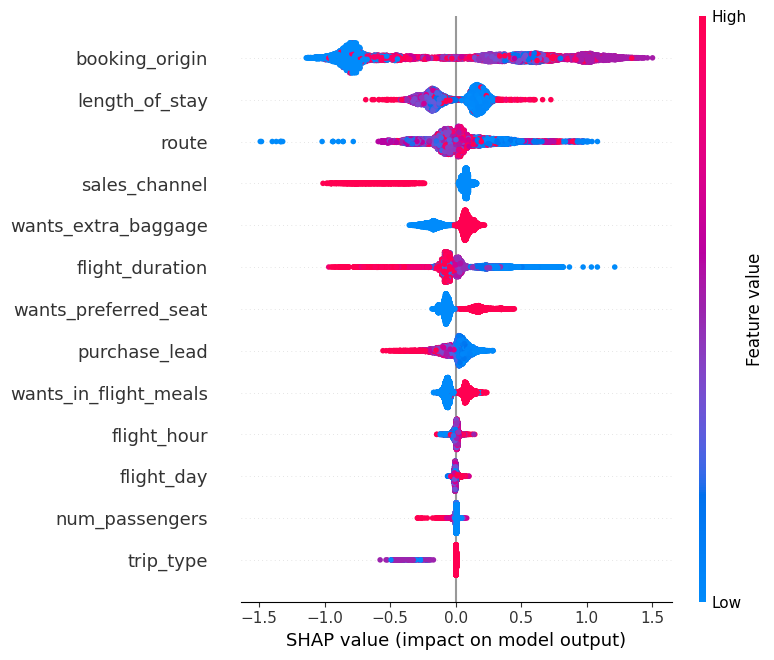

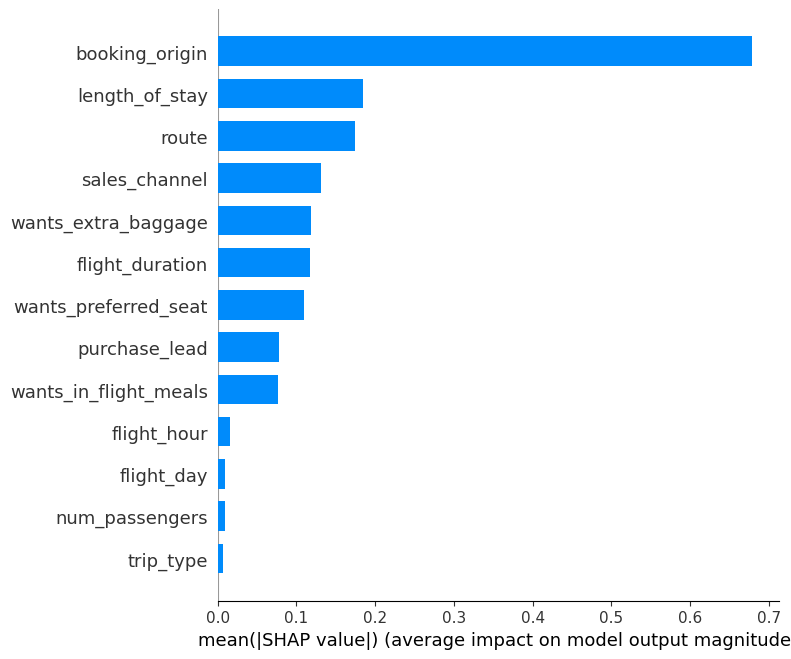

In [18]:
# Explain model predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

# Plot SHAP feature importance
shap.summary_plot(shap_values, X_test, plot_type='bar')
